Importação das Bibliotecas

In [4]:
import os
import zipfile
import shutil
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import concurrent.futures
import matplotlib.pyplot as plt

import rasterio as rs
from skimage.transform import resize

Inicialização das Variáveis que seram utilizadas dirante a execução do código

In [5]:
IMG_HEIGHT = 64  # Definir a altura das imagens
IMG_WIDTH = 64   # Definir a largura das imagens
IMG_MASK_CHANNELS = 1  # Número de canais de imagem mascara
IMG_CHANNELS = 2  # Número de canais de imagem (bandas 06 e 07)
IMG_COLOR_CHANNELS = 3  # Número de canais de imagem coloridas
TAMANHO_RECORTE = IMG_HEIGHT
NUMERO_IMAGEN = 1

Diretório das Imagens e Saídas de .CSV e DataFrame

In [8]:
# Local onde as imagens seram salvas em seu computador
# path = "/home/cristiano/Imagens/"
path = "/home/emanoelcepr/Imagens/"

# # Teste Landsat-8
origem = path + "imagens_originais/Landsat-8/teste/"
diretorio_imagens =  path + "imagens_originais/Landsat-8/teste_processadas/"

Neste ponto é criado a estrutura que será a entrada para o treinamento da Rede Neural Convolucional. 

Sentinel-2

In [9]:
# Função para redimensionar as imagens de entrada para o tamanho desejado
def redimensionar_imagem(imagem, altura_desejada, largura_desejada):
    return resize(imagem, (altura_desejada, largura_desejada), mode='constant', preserve_range=True)

# Obter número de imagens de treino
NUM_TRAIN_IMAGES = len([f for f in os.listdir(diretorio_imagens) if "Mask" in f])

# Obter listas de nomes de arquivo Sentinel-2
banda06_list = sorted([f for f in os.listdir(diretorio_imagens) if "B06_(Raw)" in f])
banda07_list = sorted([f for f in os.listdir(diretorio_imagens) if "B07_(Raw)" in f])
seg_list = sorted([f for f in os.listdir(diretorio_imagens) if "Mask" in f])

with pd.option_context("display.max_columns", None):
    df = pd.DataFrame({'banda06': banda06_list, 'banda07': banda07_list, 'seg': seg_list})

# Obter listas de IDs
train_banda06_id_list = df['banda06'].tolist()
train_banda07_id_list = df['banda07'].tolist()
train_mask_id_list = df['seg'].tolist()

X_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_MASK_CHANNELS), dtype=bool)


# Iterar sobre as listas usando enumerate
for i, (banda06_id, banda07_id, mask_id) in enumerate(zip(train_banda06_id_list, train_banda07_id_list, train_mask_id_list)):
    # Construir caminhos completos
    path_banda06 = os.path.join(diretorio_imagens, banda06_id)
    path_banda07 = os.path.join(diretorio_imagens, banda07_id)
    path_seg = os.path.join(diretorio_imagens, mask_id)
    
    try:
        # Ler as imagens
        with rs.open(path_banda06) as img06, rs.open(path_banda07) as img07, rs.open(path_seg) as img_seg:
            banda06 = img06.read(1)
            banda07 = img07.read(1)
            seg = img_seg.read(1)
            
        # Juntar as bandas
        bandas = np.dstack((banda06, banda07))

        # Redimensionar as bandas para o tamanho desejado
        bandas_redimensionadas = redimensionar_imagem(bandas, IMG_HEIGHT, IMG_WIDTH)

        # Transformar bandas em valores entre 0 e 255
        bandas_redimensionadas = (bandas_redimensionadas / np.max(bandas_redimensionadas)) * 255

        # Inserir a imagem em X_train/X_test
        X_test[i] = bandas_redimensionadas

        # Redimensionar a máscara para a forma (IMG_HEIGHT, IMG_WIDTH, 1)
        mask = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

        # Normalizar valores da máscara para True/False (ou 0/1)
        mask = mask.astype(bool)

        # Inserir a máscara em X_train/Y_test
        Y_test[i] = mask
    except (rs.errors.RasterioIOError, FileNotFoundError) as e:
        print(f"Erro ao abrir a imagem {banda06_id}: {e}")

print('Shape do X_test:', X_test.shape)
print('Shape do Y_test:', Y_test.shape)

/home/emanoelcepr/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape do X_test: (76, 64, 64, 2)
Shape do Y_test: (76, 64, 64, 1)


Neste ponto é criado a estrutura que será a entrada para o treinamento da Rede Neural Convolucional. 

Landsat-8

Salva as entradas da Rede

In [10]:
# Salvar X_test
X_test_file = os.path.join(diretorio_imagens, 'X_test.npy')
np.save(X_test_file, X_test)

# Salvar Y_train
Y_test_file = os.path.join(diretorio_imagens, 'Y_test.npy')
np.save(Y_test_file, Y_test)

Visualização de uma imagem a partir dos arquivos salvos.

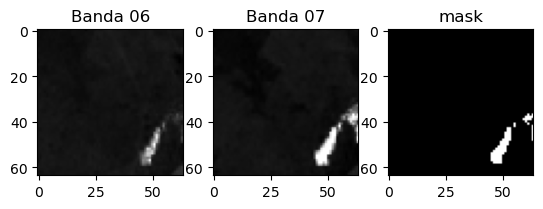

In [15]:

# Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
bandas = X_test[0]
mask = Y_test[0]

# Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
banda11 = bandas[:, :, 0]
banda12 = bandas[:, :, 1]

# Plotar as bandas individualmente
plt.subplot(1, 3, 1)
plt.imshow(banda11, cmap='gray')
plt.title('Banda 06')

plt.subplot(1, 3, 2)
plt.imshow(banda12, cmap='gray')
plt.title('Banda 07')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('mask')

plt.show()

vou passar o indice e a posição do pixel e a função vai no diretório onde esta salvo as imagem e vai procurar no meta dados a longitute e a latitude da imagem.